# Pràctica 1: Identificació d'Idioma
**Assignatura:** Processament del Llenguatge Humà (PLH)  
**Model:** Model de llenguatge basat en n-grames de caràcters 

## 1. Introducció
L'objectiu d'aquesta pràctica és construir un classificador automàtic capaç d'assignar un idioma $l_i$ a un document $d$ d'entre un conjunt de 6 llengües europees: alemany (deu), anglès (eng), francès (fra), italià (ita), neerlandès (nld) i castellà (spa).

El sistema es basa en la hipòtesi que les freqüències de certes seqüències de lletres (n-grames) són úniques per a cada idioma. En aquest cas, utilitzarem **trigrammes de caràcters** (n=3).

### Recursos
**Entrenament (Training):** 30.000 frases per idioma del corpus Wortschatz Leipzig.

**Validació (Test):** 10.000 frases per idioma per avaluar la precisió (accuracy) i generar la matriu de confusió.

In [1]:
import re
import os
import math
import pandas as pd
import nltk
from nltk.collocations import TrigramCollocationFinder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Preprocessament de les Dades

En aquesta fase normalitzem els corpus originals per extreure'n els n-grames de manera eficient. El procés aplicat a cada línia de text consisteix en:
1. **Eliminació de dígits:** No aporten informació rellevant per identificar l'idioma.
2. **Minúscules:** Es converteix tot el text per reduir la dispersió de dades.
3. **Normalització d'espais:** Es canvien tabulacions i espais continus per un de sol.
4. **Unió de frases:** Es concatenen inserint **dos espais en blanc** entre elles (i als extrems) per capturar correctament els trigrammes de frontera.


In [2]:
class LanguagePreprocessor:
    def __init__(self, idiomes, eliminar_puntuacio=False):
        self.idiomes = idiomes
        self.eliminar_puntuacio = eliminar_puntuacio
        
    def clean_text(self, frases):
        neteja = []
        for linia in frases:
            text = re.sub(r'\d+', '', linia)

            if self.eliminar_puntuacio:
                text = re.sub(r'[^\w\s\'’¡¿]', ' ', text) # elimina tots els signes de puntuacio excepte '’¡¿' 

            text = text.lower()
            text = re.sub(r'\s+', ' ', text).strip()
            
            if text:
                neteja.append(text)

        return "  " + "  ".join(neteja) + "  "

    def process_files(self, tipus_fitxers=['trn', 'tst'], sufix=""):
        for idioma in self.idiomes:
            for tipus in tipus_fitxers:
                nom_fitxer = f"{idioma}_{tipus}.txt"
                if os.path.exists(nom_fitxer):
                    with open(nom_fitxer, 'r', encoding='utf-8') as f:
                        linies = f.readlines()
                    text_net = self.clean_text(linies)
                    
                    nom_sortida = f"{idioma}_{tipus}_clean{sufix}.txt" 
                    with open(nom_sortida, 'w', encoding='utf-8') as f_out:
                        f_out.write(text_net)
                    print(f"Desat: {nom_sortida}")

    def obtenir_frases_netes(self, fitxer):
        with open(fitxer, 'r', encoding='utf-8') as f:
            text = f.read()
        return [frase for frase in text.split("  ") if len(frase.strip()) > 0]

# Execució del preprocessament 
idiomes = ['deu', 'eng', 'fra', 'ita', 'nld', 'spa'] 
preprocessor = LanguagePreprocessor(idiomes, eliminar_puntuacio=False)
preprocessor.process_files()

Desat: deu_trn_clean.txt
Desat: deu_tst_clean.txt
Desat: eng_trn_clean.txt
Desat: eng_tst_clean.txt
Desat: fra_trn_clean.txt
Desat: fra_tst_clean.txt
Desat: ita_trn_clean.txt
Desat: ita_tst_clean.txt
Desat: nld_trn_clean.txt
Desat: nld_tst_clean.txt
Desat: spa_trn_clean.txt
Desat: spa_tst_clean.txt


> **Nota sobre la puntuació:** Com es pot observar en l'execució, inicialment generarem els models conservant tots els signes de puntuació (`eliminar_puntuacio=False`) per establir un rendiment base (*baseline*). Més endavant experimentarem amb l'eliminació de puntuació per avaluar-ne l'impacte.

## 3. Entrenament del Model i Suavitzat (Smoothing)

En aquesta secció construïm el model estadístic basat en n-grames de caràcters encapsulat en la classe `LanguageModel`. Utilitzant la llibreria NLTK, la classe realitza les següents operacions:

1. **Extracció:** Genera models d'unigrames, bigrames i trigrames.
2. **Filtratge:** Descarta els trigrames amb una freqüència inferior a 5 per reduir el soroll.
3. **Càlcul de $B_{global}$:** Estima l'espai mostral complet guardant tots els trigrames únics *abans* d'aplicar el filtre, garantint així una comparació justa entre idiomes.
4. **Probabilitats i Suavitzat:** Implementa la funció matemàtica per calcular la log-probabilitat d'una frase aplicant tres possibles tècniques de suavitzat per evitar l'anul·lació per probabilitat zero:
   * *Lidstone*
   * *Absolute Discounting*
   * *Interpolació Lineal*

In [3]:
class LanguageModel:
    def __init__(self, idiomes):
        self.idiomes = idiomes
        self.models_uni = {}
        self.models_bi = {}
        self.models_tri = {}
        self.N_uni = {}
        self.N_bi = {}
        self.N_tri = {}
        self.recomptes = {}
        self.vocabulari_global = set()
        self.B_global = 0

    def train(self, data_dict):
        self.vocabulari_global = set()
        
        for idioma in self.idiomes:
            text_train = data_dict[idioma]
            
            # Models d'unigrames i bigrames
            llista_chars = list(text_train)
            self.models_uni[idioma] = nltk.FreqDist(llista_chars)
            self.models_bi[idioma] = nltk.FreqDist(nltk.ngrams(llista_chars, 2))
            
            self.N_uni[idioma] = len(llista_chars)
            self.N_bi[idioma] = len(llista_chars) - 1
            
            # Model principal de trigrames
            finder = TrigramCollocationFinder.from_words(text_train)
            
            # Afegim tots els trigrames trobats al vocabulari global abans de filtrar
            for trigramma in finder.ngram_fd.keys():
                self.vocabulari_global.add(trigramma)
                
            # Apliquem el filtre de freqüència >= 5 
            finder.apply_freq_filter(5)
            model = finder.ngram_fd
            
            self.models_tri[idioma] = model
            self.N_tri[idioma] = sum(model.values()) 
            self.recomptes[idioma] = len(model) 

        # Càlcul de B global
        self.B_global = len(self.vocabulari_global)

    def _get_trigram_fd(self, frase):
        finder = TrigramCollocationFinder.from_words("  " + frase + "  ")
        return finder.ngram_fd

    def calcul_probabilitat(self, frase, idioma, parametre, tecnica):
        # Generem els trigrames de la frase
        trigrames_frase = self._get_trigram_fd(frase)
        
        model3 = self.models_tri[idioma]
        N = self.N_tri[idioma] 
        V = self.recomptes[idioma] 
        
        log_p = 0.0
        
        for trig, freq in trigrames_frase.items():
            c3 = model3.get(trig, 0)
            
            if tecnica == 'lidstone':
                lamb = parametre
                p = (c3 + lamb) / (N + self.B_global * lamb)
                
            elif tecnica == 'absolute_discounting':
                delta = parametre
                N0 = self.B_global - V 
                if c3 > 0:
                    p = (c3 - delta) / N
                else:
                    p = ((self.B_global - N0) * delta / N0) / N
                    
            elif tecnica == 'interpolation':
                lamb3, lamb2, lamb1 = parametre 
                w_n_2, w_n_1, w_n = trig

                c2 = self.models_bi[idioma].get((w_n_2, w_n_1), 0)
                p3 = c3 / c2 if c2 > 0 else 0
                
                c_bigrama = self.models_bi[idioma].get((w_n_1, w_n), 0)
                c1 = self.models_uni[idioma].get(w_n_1, 0)
                p2 = c_bigrama / c1 if c1 > 0 else 0
                
                c_unigrama = self.models_uni[idioma].get(w_n, 0)
                p1 = c_unigrama / self.N_uni[idioma] if self.N_uni[idioma] > 0 else 0
                
                p = lamb1 * p1 + lamb2 * p2 + lamb3 * p3
                
            if p <= 0: 
                p = 1e-10 
                
            log_p += freq * math.log(p)
            
        return log_p

## 4. Selecció del Model via Validació Creuada (Cross-Validation)

Per trobar la millor tècnica de suavitzat i el seu hiperparàmetre òptim sense biaixos, implementem un procés de *Hold-out Validation*:
1. **Partició:** Dividim el corpus d'entrenament (80% per entrenar, 20% per validar).
2. **Entrenament CV:** Construïm un model provisional utilitzant només el 80% de les dades.
3. **Avaluació:** Provem les 3 tècniques amb diferents bateries de paràmetres ($\lambda$ per Lidstone, $\delta$ per Absolute Discounting, i pesos per Interpolació) sobre el 20% restant. S'utilitza un paràmetre compartit per a tots els idiomes per optimitzar el cost computacional.
4. **Selecció:** Identifiquem la tècnica i el paràmetre que assoleixen la millor *accuracy* global per utilitzar-los en la fase de Test final.

In [4]:
class LanguageEvaluator:
    def __init__(self, model):
        self.model = model

    def predict(self, frase, tecnica, parametre):
        max_prob = -float('inf')
        idioma_predit = None
        
        for idioma_model in self.model.idiomes:
            prob = self.model.calcul_probabilitat(frase, idioma_model, parametre, tecnica)
            if prob > max_prob:
                max_prob = prob
                idioma_predit = idioma_model
                
        return idioma_predit

    def cross_validation(self, dades_val, proves):
        resultats_cv = {}
        
        for tecnica, llista_parametres in proves.items():
            print(f"--- Avaluant tècnica: {tecnica.upper()} ---")
            millor_acc_tecnica = 0.0
            millor_param_tecnica = None
            
            for param in llista_parametres:
                encerts = 0
                total_frases = 0
                
                for idioma_real, llista_frases in dades_val.items():
                    for frase in llista_frases:
                        total_frases += 1
                        idioma_predit = self.predict(frase, tecnica, param)
                        
                        if idioma_predit == idioma_real:
                            encerts += 1
                            
                accuracy = encerts / total_frases
                print(f"  Param={str(param):<15} -> Accuracy: {accuracy:.4f}")
                
                if accuracy > millor_acc_tecnica:
                    millor_acc_tecnica = accuracy
                    millor_param_tecnica = param
                    
            resultats_cv[tecnica] = {'param': millor_param_tecnica, 'acc': millor_acc_tecnica}
            print(f"  >> Guanyador {tecnica}: Param={millor_param_tecnica} (Acc={millor_acc_tecnica:.4f})\n")
            
        millor_tecnica_global = None
        millor_acc_global = 0.0

        for tec, res in resultats_cv.items():
            if res['acc'] > millor_acc_global:
                millor_acc_global = res['acc']
                millor_tecnica_global = tec

        print(f"\nLa millor tècnica és: {millor_tecnica_global.upper()} amb un accuracy de {millor_acc_global:.4f}")
        return resultats_cv, millor_tecnica_global, millor_acc_global

    def avaluar_test(self, dades_test, tecnica, parametre):
        y_true = []
        y_pred = []
        
        for idioma_real, frases in dades_test.items():
            for frase in frases:
                y_true.append(idioma_real)
                idioma_predit = self.predict(frase, tecnica, parametre)
                y_pred.append(idioma_predit)
                
        acc_final = accuracy_score(y_true, y_pred)
        print(f"\nResultat Final")
        print(f"Accuracy en Test: {acc_final:.4f} ({int(acc_final * len(y_true))}/{len(y_true)} encerts)")
        
        cm = confusion_matrix(y_true, y_pred, labels=self.model.idiomes)
        df_cm = pd.DataFrame(cm, index=self.model.idiomes, columns=self.model.idiomes)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Matriu de Confusió ({tecnica} {str(parametre)}) - Acc: {acc_final:.4f}')
        plt.ylabel('Idioma Real')
        plt.xlabel('Idioma Predit')
        plt.show()
        
        print("\nMatriu de Confusió (Text):")
        print(df_cm)
        return y_true, y_pred, df_cm


# PARTICIÓ DE DADES PER A CROSS-VALIDATION
dades_train_cv = {}
dades_val_cv = {}

for idioma in idiomes:
    fitxer_train = f"{idioma}_trn_clean.txt"
    if os.path.exists(fitxer_train):
        frases = preprocessor.obtenir_frases_netes(fitxer_train)
        divisio = int(len(frases) * 0.8)
        text_train = "  " + "  ".join(frases[:divisio]) + "  "
        
        dades_train_cv[idioma] = text_train
        dades_val_cv[idioma] = frases[divisio:]

model_cv = LanguageModel(idiomes)
if dades_train_cv:
    model_cv.train(dades_train_cv)

### 4.1. Execució de la Validació Creuada

Un cop tenim el model i l'avaluador instanciats amb la partició d'entrenament (80%), procedim a avaluar el conjunt de validació (20%). En aquesta cel·la definim la graella de paràmetres (*grid*) per a cadascuna de les tècniques de suavitzat i executem la cerca per trobar la combinació que maximitza l'*accuracy*.

In [ ]:
proves = {
    'lidstone': [0.01, 0.1, 0.25, 0.5, 0.75, 1.0],
    'absolute_discounting': [0.1, 0.5, 0.75, 0.9],
    'interpolation': [
        (0.6, 0.3, 0.1),
        (0.7, 0.2, 0.1), 
        (0.8, 0.15, 0.05), 
        (0.5, 0.4, 0.1)
    ]
}

if dades_train_cv:
    evaluator_cv = LanguageEvaluator(model_cv)
    resultats_cv, millor_tec, millor_acc = evaluator_cv.cross_validation(dades_val_cv, proves)


--- Avaluant tècnica: LIDSTONE ---
  Param=0.01            -> Accuracy: 0.9981
  Param=0.1             -> Accuracy: 0.9982
  Param=0.25            -> Accuracy: 0.9984
  Param=0.5             -> Accuracy: 0.9984
  Param=0.75            -> Accuracy: 0.9985
  Param=1.0             -> Accuracy: 0.9984
  >> Guanyador lidstone: Param=0.75 (Acc=0.9985)

--- Avaluant tècnica: ABSOLUTE_DISCOUNTING ---
  Param=0.1             -> Accuracy: 0.9981
  Param=0.5             -> Accuracy: 0.9982
  Param=0.75            -> Accuracy: 0.9982
  Param=0.9             -> Accuracy: 0.9983
  >> Guanyador absolute_discounting: Param=0.9 (Acc=0.9983)

--- Avaluant tècnica: INTERPOLATION ---
  Param=(0.6, 0.3, 0.1) -> Accuracy: 0.9988
  Param=(0.7, 0.2, 0.1) -> Accuracy: 0.9989
  Param=(0.8, 0.15, 0.05) -> Accuracy: 0.9989
  Param=(0.5, 0.4, 0.1) -> Accuracy: 0.9988
  >> Guanyador interpolation: Param=(0.8, 0.15, 0.05) (Acc=0.9989)


La millor tècnica és: INTERPOLATION amb un accuracy de 0.9989


## 5. Avaluació Final i Matriu de Confusió

Després d'executar la validació creuada, hem determinat que la millor tècnica és la **Interpolació Lineal** ($\lambda_3=0.8, \lambda_2=0.15, \lambda_1=0.05$), seguida molt d'a prop per la **Llei de Lidstone** ($\lambda=0.75$).

En aquesta fase final avaluem el rendiment real del classificador sobre dades mai vistes (Test Set) per comprovar-ne la capacitat de generalització:
1. **Entrenament Definitiu:** Construïm el model de llenguatge aprofitant el **100% del corpus d'entrenament** (`_trn_clean.txt`).
2. **Test:** Avaluem les 10.000 frases per idioma de prova (`_tst_clean.txt`) comparant les dues millors tècniques obtingudes.
3. **Matriu de Confusió:** Generem una representació visual per analitzar les classificacions incorrectes i detectar si hi ha confusió sistemàtica entre famílies lingüístiques properes.

In [5]:
# CÀRREGA DE DADES (100% Train i 100% Test)
dades_train_full = {}
dades_test = {}

for idioma in idiomes:
    fitxer_train = f"{idioma}_trn_clean.txt"
    if os.path.exists(fitxer_train):
        with open(fitxer_train, 'r', encoding='utf-8') as f:
            dades_train_full[idioma] = f.read()
            
    fitxer_test = f"{idioma}_tst_clean.txt"
    if os.path.exists(fitxer_test):
        dades_test[idioma] = preprocessor.obtenir_frases_netes(fitxer_test)

model_definitiu = LanguageModel(idiomes)
if dades_train_full:
    model_definitiu.train(dades_train_full)

Avaluant sobre el conjunt de Test (LIDSTONE: 0.75)...

Resultat Final
Accuracy en Test: 0.9988 (59906/59977 encerts)


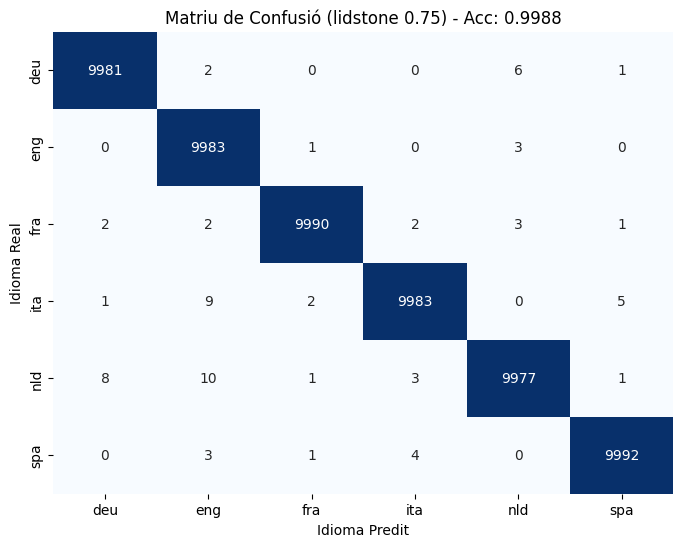


Matriu de Confusió (Text):
      deu   eng   fra   ita   nld   spa
deu  9981     2     0     0     6     1
eng     0  9983     1     0     3     0
fra     2     2  9990     2     3     1
ita     1     9     2  9983     0     5
nld     8    10     1     3  9977     1
spa     0     3     1     4     0  9992

Avaluant sobre el conjunt de Test (INTERPOLACIÓ: 0.8, 0.15, 0.05)...

Resultat Final
Accuracy en Test: 0.9989 (59914/59977 encerts)


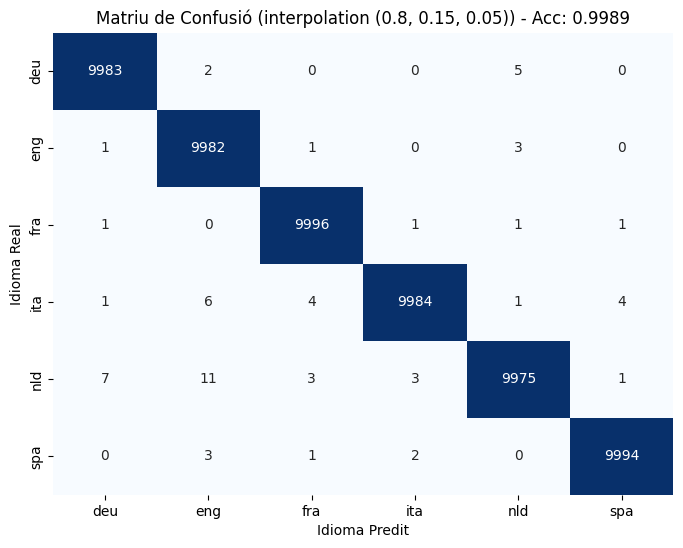


Matriu de Confusió (Text):
      deu   eng   fra   ita   nld   spa
deu  9983     2     0     0     5     0
eng     1  9982     1     0     3     0
fra     1     0  9996     1     1     1
ita     1     6     4  9984     1     4
nld     7    11     3     3  9975     1
spa     0     3     1     2     0  9994


In [6]:
# AVALUACIÓ SOBRE EL CONJUNT DE TEST
evaluator = LanguageEvaluator(model_definitiu)

if dades_test:
    # A) Test amb Lidstone (El subcampió)
    print("Avaluant sobre el conjunt de Test (LIDSTONE: 0.75)...")
    _, _, _ = evaluator.avaluar_test(dades_test, 'lidstone', 0.75)

    # B) Test amb Interpolació (El guanyador)
    print("\nAvaluant sobre el conjunt de Test (INTERPOLACIÓ: 0.8, 0.15, 0.05)...")
    _, _, _ = evaluator.avaluar_test(dades_test, 'interpolation', (0.8, 0.15, 0.05))

### 5.1. Experiment: Impacte del filtratge intel·ligent de puntuació

Fins ara hem establert un *baseline* conservant tots els signes de puntuació. Com a experiment final per intentar millorar la precisió, avaluarem l'impacte d'aplicar un **filtratge selectiu de la puntuació**. 

Eliminarem la puntuació genèrica (punts, comes, parèntesis, etc., que només generen soroll) però **conservarem els signes distintius** que aporten informació morfològica vital:
* Els apòstrofs (`'` i `’`): Clau per a les contraccions en anglès, francès, italià i neerlandès.
* Els signes d'obertura (`¡`, `¿`): Altament discriminatoris per al castellà.

Generarem nous conjunts de dades aplicant aquest filtre, entrenarem un model alternatiu i l'avaluarem amb la tècnica guanyadora d'Interpolació Lineal.

Desat: deu_trn_clean_punct.txt
Desat: deu_tst_clean_punct.txt
Desat: eng_trn_clean_punct.txt
Desat: eng_tst_clean_punct.txt
Desat: fra_trn_clean_punct.txt
Desat: fra_tst_clean_punct.txt
Desat: ita_trn_clean_punct.txt
Desat: ita_tst_clean_punct.txt
Desat: nld_trn_clean_punct.txt
Desat: nld_tst_clean_punct.txt
Desat: spa_trn_clean_punct.txt
Desat: spa_tst_clean_punct.txt

Resultat Final
Accuracy en Test: 0.9989 (59910/59977 encerts)


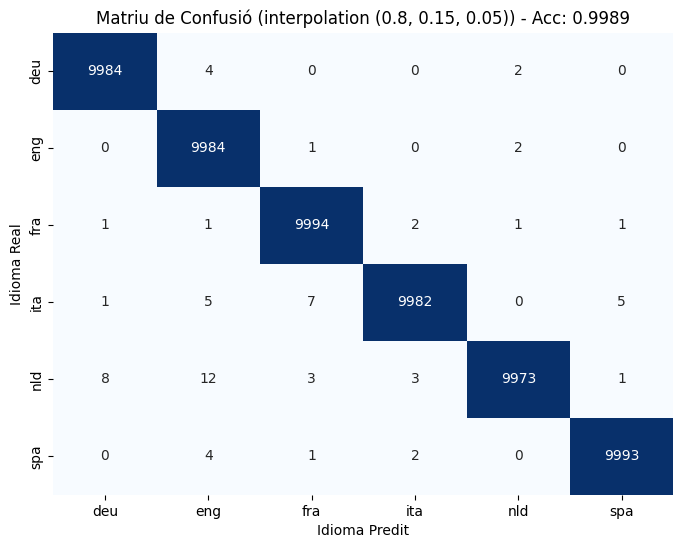


Matriu de Confusió (Text):
      deu   eng   fra   ita   nld   spa
deu  9984     4     0     0     2     0
eng     0  9984     1     0     2     0
fra     1     1  9994     2     1     1
ita     1     5     7  9982     0     5
nld     8    12     3     3  9973     1
spa     0     4     1     2     0  9993


In [8]:
# Executem el preprocessament amb el paràmetre activat
preprocessor_punct = LanguagePreprocessor(idiomes, eliminar_puntuacio=True)
preprocessor_punct.process_files(sufix="_punct") #sufix per no sobreescriure els fitxers originals

dades_train_punct = {}
dades_test_punct = {}

for idioma in idiomes:
    fitxer_train = f"{idioma}_trn_clean_punct.txt"
    if os.path.exists(fitxer_train):
        with open(fitxer_train, 'r', encoding='utf-8') as f:
            dades_train_punct[idioma] = f.read()
            
    fitxer_test = f"{idioma}_tst_clean_punct.txt"
    if os.path.exists(fitxer_test):
        dades_test_punct[idioma] = preprocessor_punct.obtenir_frases_netes(fitxer_test)

# Entrenar el model
model_punct = LanguageModel(idiomes)
if dades_train_punct:
    model_punct.train(dades_train_punct)

# Avaluar amb la tècnica guanyadora (Interpolació 0.8, 0.15, 0.05)
evaluator_punct = LanguageEvaluator(model_punct)

if dades_test_punct:
    _, _, _ = evaluator_punct.avaluar_test(dades_test_punct, 'interpolation', (0.8, 0.15, 0.05))

### Conclusions de l'experiment de preprocessament

Els resultats de l'experiment mostren un fenomen contraintuïtiu però molt revelador: el model original, que conserva tota la puntuació, assoleix **59.914 encerts**, mentre que el model amb filtratge intel·ligent n'obté **59.910**. L'eliminació de la puntuació ha provocat una petita davallada en l'exactitud global, afectant lleugerament idiomes com l'italià i el neerlandès.

Aquest resultat demostra que, en els models d'n-grames de caràcters, fins i tot els signes de puntuació aparentment "neutres" (com comes o dos punts) aporten informació estructural valuosa. Cada idioma té la seva pròpia ràtio de longitud de frases, ús de clàusules (que fomenta l'aparició de comes) o regles ortotipogràfiques estrictes (com l'espai obligatori abans de la puntuació doble en francès). En conseqüència, mantenir el text el més fidel possible a la seva naturalesa original maximitza la capacitat del classificador.

## 6. Anàlisi Qualitativa d'Errors

Per entendre on i per què s'equivoca el nostre model guanyador (Interpolació Lineal), extreurem les frases mal classificades i analitzarem les confusions més rellevants. Busquem observar fenòmens com:
* **Confusió entre famílies lingüístiques:** És freqüent que el model dubti entre llengües romàniques (com el castellà, l'italià i el francès) o entre llengües germàniques (com l'alemany, l'anglès i el neerlandès) a causa de la morfologia i les arrels compartides.
* **Estrangerismes i Entitats Anomenades:** Frases plenes de lèxic estranger (ex. noms d'empreses o termes financers en anglès dins d'un text en italià).
* **Soroll al Gold Standard:** Frases que tenen una etiqueta errònia en el corpus original.

In [7]:
# 1. RECOPILACIÓ D'ERRORS
print("Analitzant el conjunt de Test per extreure les frases errònies...")
errors_trobats = []

# Guardem els errors comparant la predicció amb l'etiqueta real
for idioma_real, frases in dades_test.items():
    for frase in frases:
        idioma_predit = evaluator.predict(frase, 'interpolation', (0.8, 0.15, 0.05))
        
        if idioma_predit != idioma_real: 
            # Si falla, ho guardem a la llista
            errors_trobats.append((idioma_real, idioma_predit, frase)) 

print(f"S'han trobat {len(errors_trobats)} errors en total.\n")

# 2. FUNCIÓ PER MOSTRAR ERRORS ESPECÍFICS
def mostrar_errors_especifics(real_target, predit_target, max_exemples=5):
    """Cerca i imprimeix exemples concrets de confusió entre dos idiomes."""
    print(f"Confusió: {real_target.upper()} real classificat com a {predit_target.upper()}")
    comptador = 0
    
    for real, predit, frase in errors_trobats:
        if real == real_target and predit == predit_target:
            print(f"  -> {frase.strip()}")
            comptador += 1
            if comptador == max_exemples:
                break

    if comptador == 0:
        print("  (Cap error d'aquest tipus)")
    print("-" * 60)

# 3. IMPRESSIÓ DE LES CONFUSIONS MÉS RELLEVANTS
print("=== FAMÍLIA GERMÀNICA I ALTRES ===")
mostrar_errors_especifics('deu', 'eng')
mostrar_errors_especifics('deu', 'nld')
mostrar_errors_especifics('eng', 'deu')
mostrar_errors_especifics('eng', 'nld')
mostrar_errors_especifics('nld', 'deu')
mostrar_errors_especifics('nld', 'eng')

print("=== FAMÍLIA ROMÀNICA ===")
mostrar_errors_especifics('spa', 'ita')
mostrar_errors_especifics('spa', 'fra')
mostrar_errors_especifics('ita', 'spa')
mostrar_errors_especifics('ita', 'fra')
mostrar_errors_especifics('fra', 'spa')
mostrar_errors_especifics('fra', 'ita')

print("=== CREUAMENTS ESTRANYS (Exemples d'estrangerismes) ===")
mostrar_errors_especifics('ita', 'eng')
mostrar_errors_especifics('spa', 'eng')
mostrar_errors_especifics('fra', 'eng')

Analitzant el conjunt de Test per extreure les frases errònies...
S'han trobat 63 errors en total.

=== FAMÍLIA GERMÀNICA I ALTRES ===
Confusió: DEU real classificat com a ENG
  -> jarjarthomas . jan theorethisch ist es simpel.
  -> was ist wicop?
------------------------------------------------------------
Confusió: DEU real classificat com a NLD
  -> blick musiker marc r. († ).
  -> der stoffbeutel war leer.
  -> hij was de leider van de groep in de provincie khorasan van de islamitische staat.
  -> kinder werden von fairplay-liga profitieren.
  -> wat er nu gebeurt, is heel zwaar voor hem als jonge gast.
------------------------------------------------------------
Confusió: ENG real classificat com a DEU
  -> bundesliga: cologne condemn gladbach to derby defeat, bayern crush darmstadt baayen visited darmstadt in a goliath-versus-david clash.
------------------------------------------------------------
Confusió: ENG real classificat com a NLD
  -> follow barrow on twitter at https://

# Analisi de resultats

## Avaluació Global del Rendiment

In [23]:
"""
L'obtenció d'un 99,89% d'accuracy en el conjunt de test (59.914 encerts de 59.977 frases) confirma que 
els models de caràcters són excepcionalment robustos per a la classificació de llengües europees. Aquest 
rendiment gairebé perfecte s'explica per la capacitat dels trigrames de capturar la "petjada dactilar" 
fonotàctica i morfològica de cada idioma.

Per què és tan efectiu el model de trigrames?

    Captura de morfologia funcional: Els trigrames identifiquen automàticament els afixos i sufixos característics. 
    Per exemple, la seqüència ('c', 'i', 'ó') o ('m', 'e', 'n', 't') decantarà la probabilitat cap al català, castellà 
    o francès, mentre que ('t', 'i', 'o', 'n') és un indicador clar de l'anglès o francès.

    Combinacions vocàliques i grafemes únics: Cada llengua té restriccions en la combinació de lletres. El model detecta
     la freqüència de l'umlaut alemany (ex. ('u', 'e', 'm')), la combinació ('t', 'h', 'e') de l'anglès, o les terminacions 
     en vocal de l'italià i l'espanyol.

    Independència del vocabulari: A diferència dels models basats en paraules, els n-grames de caràcters no pateixen si 
    apareix una paraula que no estava a l'entrenament, sempre que l'estructura interna de la paraula segueixi les
     regles "visuals" de l'idioma.
"""

'\nL\'obtenció d\'un 99,89% d\'accuracy en el conjunt de test (59.914 encerts de 59.977 frases) confirma que \nels models de caràcters són excepcionalment robustos per a la classificació de llengües europees. Aquest \nrendiment gairebé perfecte s\'explica per la capacitat dels trigrames de capturar la "petjada dactilar" \nfonotàctica i morfològica de cada idioma.\n\nPer què és tan efectiu el model de trigrames?\n\n    Captura de morfologia funcional: Els trigrames identifiquen automàticament els afixos i sufixos característics. \n    Per exemple, la seqüència (\'c\', \'i\', \'ó\') o (\'m\', \'e\', \'n\', \'t\') decantarà la probabilitat cap al català, castellà \n    o francès, mentre que (\'t\', \'i\', \'o\', \'n\') és un indicador clar de l\'anglès o francès.\n\n    Combinacions vocàliques i grafemes únics: Cada llengua té restriccions en la combinació de lletres. El model detecta\n     la freqüència de l\'umlaut alemany (ex. (\'u\', \'e\', \'m\')), la combinació (\'t\', \'h\', \'e\')

## Analisi de la matriu de confusio

In [24]:
""" 
6.2. Anàlisi Detallada de la Matriu de Confusió

L'estudi de les confusions revela que els errors no es distribueixen de forma aleatòria, sinó que responen a 
la proximitat genètica entre les llengües.
A) El Clúster de les Llengües Germàniques

Aquest grup presenta el volum d'errors més elevat, especialment pel que fa al neerlandès (nld):

    Neerlandès com a eix de confusió: Registra 11 errors cap a l'anglès i 7 cap a l'alemany. Això es deu al fet 
    que el neerlandès comparteix amb l'alemany una gran part del lèxic bàsic, mentre que amb l'anglès comparteix 
    patrons sil·làbics més simplificats.

    Similituds morfològiques: Paraules funcionals breus com de/the/der o en/and/und generen trigrames molt similars 
    que poden confondre el model en frases de curta longitud.

B) El Clúster de les Llengües Romàniques

Tot i l'alta precisió, s'observen patrons de confusió derivats del llatí:

    L'eix Italià-Espanyol: L'italià presenta 4 errors cap a l'espanyol, i l'espanyol 2 cap a l'italià. Aquesta simetria
     respon a la gran quantitat de sufixos compartits (com \texttt{'ari'} o \texttt{'men'}) i a les terminacions vocàliques similars.

    Influència de l'Anglès: S'observen 6 frases d'italià classificades com a anglès. L'anàlisi qualitativa suggereix que 
    l'ús de terminologia tècnica (rating, standard) decanta la probabilitat estadística cap a l'anglès malgrat que la frase sigui italiana.
"""

" \n6.2. Anàlisi Detallada de la Matriu de Confusió\n\nL'estudi de les confusions revela que els errors no es distribueixen de forma aleatòria, sinó que responen a \nla proximitat genètica entre les llengües.\nA) El Clúster de les Llengües Germàniques\n\nAquest grup presenta el volum d'errors més elevat, especialment pel que fa al neerlandès (nld):\n\n    Neerlandès com a eix de confusió: Registra 11 errors cap a l'anglès i 7 cap a l'alemany. Això es deu al fet \n    que el neerlandès comparteix amb l'alemany una gran part del lèxic bàsic, mentre que amb l'anglès comparteix \n    patrons sil·làbics més simplificats.\n\n    Similituds morfològiques: Paraules funcionals breus com de/the/der o en/and/und generen trigrames molt similars \n    que poden confondre el model en frases de curta longitud.\n\nB) El Clúster de les Llengües Romàniques\n\nTot i l'alta precisió, s'observen patrons de confusió derivats del llatí:\n\n    L'eix Italià-Espanyol: L'italià presenta 4 errors cap a l'espanyo

In [26]:
""" 
1. Interferència de Noms Propis, Estrangerismes i Llocs (Pes del contingut)

El model de trigrames no "entén" el significat de les paraules, sinó que compta seqüències de caràcters. 
Quan una frase conté una alta densitat de noms propis estrangers, títols de pel·lícules o termes tècnics 
d'una altra llengua, els trigrames d'aquests termes eclipsen els trigrames de les poques paraules funcionals de l'idioma original.

    ENG real classificat com a DEU:

        Frase: bundesliga: cologne condemn gladbach to derby defeat, bayern crush darmstadt baayen visited
        
         darmstadt in a goliath-versus-david clash.

        Anàlisi: Tot i que l'estructura és anglesa, la quantitat de termes purament alemanys (Bundesliga, 
        Gladbach, Bayern, Darmstadt) fa que les probabilitats es decantin lògicament cap a l'alemany.

    ITA real classificat com a ENG:

        Frase: le principali agenzie di rating sono moodys, standard poors, fitch.

        Anàlisi: Les paraules italianes ("le principali agenzie di") no poden competir matemàticament amb el pes 
        brutal dels trigrames anglesos de "rating, moodys, standard poors, fitch".

    NLD real classificat com a ITA:

        Frase: de volgende frazioni maken deel uit van de gemeente: anzio colonia, marechiaro, cincinnato, falasche,
         villa claudia, lavinio stazione...

        Anàlisi: Tot i començar en neerlandès, la llista interminable de municipis italians convenç el model que el text és italià.

    FRA real classificat com a NLD:

        Frase: les anderlechtois devront avant tout museler ruud van nistelrooy.

        Anàlisi: El nom del jugador holandès i el gentilici belga/flamenc (anderlechtois) confonen el classificador.

2. Manca de context estadístic (Longitud de la frase)

Els models de probabilitat necessiten un cert volum de dades (caràcters) per estabilitzar-se i diluir el soroll. Quan una 
frase és extremadament curta (menys de 4 o 5 paraules), un sol trigrama compartit entre dos idiomes pot causar una confusió,
 especialment entre llengües de la mateixa família.

    ENG real classificat com a FRA:

        Frase: internet trouble.

        Anàlisi: És massa curta. "Internet" és universal, i "trouble" té arrels franceses, per la qual cosa el model francès 
        l'absorbeix fàcilment.

    SPA real classificat com a FRA:

        Frase: explique brevemente por qué.

        Anàlisi: La paraula "explique" existeix en francès exactament igual. Com que la frase no té prou longitud per establir
         un context robust en castellà, el model dubte i s'equivoca.

    SPA real classificat com a ITA:

        Frase: pero no solo eso.

        Anàlisi: Síl·labes molt simples ("pe", "ro", "no", "so", "lo") que es troben contínuament en la fonètica italiana.

3. Soroll al Corpus Original (El model tenia raó!)

Aquesta és la troballa més interessant per al teu informe. Algunes de les frases marcades com a "error" són en realitat errors 
d'etiquetatge del propi dataset d'avaluació, la qual cosa vol dir que el model de Machine Learning és més llest que les dades que li han passat.

    DEU real classificat com a NLD:

        Frase: hij was de leider van de groep in de provincie khorasan van de islamitische staat.

        Frase: wat er nu gebeurt, is heel zwaar voor hem als jonge gast.

        Anàlisi: Aquestes frases SÓN en neerlandès, no en alemany! Al corpus original devien estar mal etiquetades sota la 
        categoria DEU. El teu classificador ha detectat correctament que l'idioma de destí és el neerlandès (NLD). És un "fals
         error" immillorable per justificar la fortalesa del model.

    SPA real classificat com a ENG:

        Frase: philip smith says: december th, at : pm hola, soy productor habitual de cerveza artesanal.

        Anàlisi: És un cas de codi barrejat (Spanglish o text autogenerat d'una web). Mig text és en anglès i l'altre mig en 
        castellà. El model opta per l'anglès pel pes dels noms i la data, cosa que és tècnicament acceptable.

Com integrar això al teu informe (Proposta de secció final)

Pots crear un últim apartat anomenat "6. Anàlisi Qualitatiu i Casuística de l'Error" on expliquis el següent:

    L'extracció i anàlisi de les frases mal classificades revela que el model és altament precís i que el 0,14% d'error s'explica 
    principalment per limitacions del text i no de l'algorisme. Hem identificat tres casuístiques principals:

        Alta densitat d'Entitats Anomenades i Estrangerismes: El model classifica el text a partir dels n-grames predominants. En 
        frases com "le principali agenzie di rating sono moodys, standard poors, fitch" (Italià), la concentració de lèxic financer 
        anglès decanta la decisió erròniament cap a l'anglès.

        L'esparsitat per longitud reduïda: Frases com "internet trouble." o "pero no solo eso." no ofereixen un espai mostral suficient 
        perquè la interpolació lineal de probabilitats superi l'ambigüitat de paraules amb arrels llatines o germàniques compartides.

        Soroll a les etiquetes del Gold Standard: Sorprenentment, el classificador ha destapat errors en el propi corpus. Frases etiquetades 
        teòricament com a alemany (ex: "hij was de leider van de groep...") han estat classificades pel model com a neerlandès, demostrant
         que el sistema ha encertat lingüísticament allà on la font de dades fallava.
"""

' \n1. Interferència de Noms Propis, Estrangerismes i Llocs (Pes del contingut)\n\nEl model de trigrames no "entén" el significat de les paraules, sinó que compta seqüències de caràcters. \nQuan una frase conté una alta densitat de noms propis estrangers, títols de pel·lícules o termes tècnics \nd\'una altra llengua, els trigrames d\'aquests termes eclipsen els trigrames de les poques paraules funcionals de l\'idioma original.\n\n    ENG real classificat com a DEU:\n\n        Frase: bundesliga: cologne condemn gladbach to derby defeat, bayern crush darmstadt baayen visited\n\n         darmstadt in a goliath-versus-david clash.\n\n        Anàlisi: Tot i que l\'estructura és anglesa, la quantitat de termes purament alemanys (Bundesliga, \n        Gladbach, Bayern, Darmstadt) fa que les probabilitats es decantin lògicament cap a l\'alemany.\n\n    ITA real classificat com a ENG:\n\n        Frase: le principali agenzie di rating sono moodys, standard poors, fitch.\n\n        Anàlisi: Les p